In [1]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import sys
import nltk
from nltk.corpus import stopwords
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import pickle
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import warnings
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
import numpy as np 
import pandas as pd
import string
import re
from tqdm._tqdm_notebook import tqdm_notebook,tnrange,tqdm
from collections import Counter,OrderedDict
from gensim import models,corpora
from gensim.summarization import summarize,keywords
import warnings
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim
import gensim.models.phrases as gen
from gensim.models.coherencemodel import CoherenceModel

# Loading Data

In [2]:
data=pd.read_json('newsgroups.json')

In [3]:
data.head(5)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [7]:
# Cheching if there is any missing value
data.isnull().sum()

content         0
target          0
target_names    0
length_text     0
length_title    0
dtype: int64

In [9]:
data.target_names.value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
sci.space                   593
comp.windows.x              593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: target_names, dtype: int64

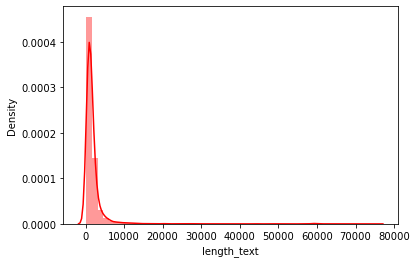

In [5]:
data['length_text'] = data['content'].str.len()
sns.distplot(data['length_text'], color="r")
plt.show()

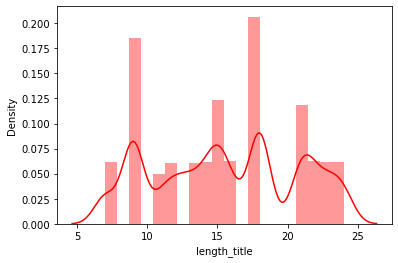

In [6]:
data['length_title'] = data['target_names'].str.len()
sns.distplot(data['length_title'], color="r")
plt.show()

In [10]:
# Take only the review_body column for unsupervised learning task
titles = [x for x in data['target_names']]
docs = [x for x in data['content']]

In [16]:
# Take a look at some of the reviews
for _ in range(5):
    print(docs[_],"\n")

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----




 

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.

In [18]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Data Preprocessing

#### We use NLTK’s Wordnet to find the meanings of words, synonyms, antonyms, and more. In addition, we use WordNetLemmatizer to get the root word. Filter out stop words.



In [19]:
# A function to prepare the text for topic modelling
def words(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    text = regex.sub(" ", text.lower())
    words = text.split(" ")
    words = [re.sub('\S*@\S*\s?', '', sent) for sent in words]
    words = [re.sub('\s+', ' ', sent) for sent in words]
    words = [re.sub("\'", "", sent) for sent in words]
    words = [w for w in words if not len(w) < 2]
    words = [w for w in words if w not in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    
    return words

In [21]:
nltk.download('wordnet')
docs = [words(x) for x in data['content']]

[nltk_data] Downloading package wordnet to C:\Users\Ibrahim
[nltk_data]     Reyad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
 # Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
print('Number of unique words in initital documents:', len(dictionary))

# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of unique words in initital documents: 82762
Number of unique words after removing rare and common words: 12805


In [26]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
#print(len(corpus))
#corpus[336]
bow_doc_300 = corpus[300]

for i in range(len(bow_doc_300)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_300[i][0], 
                                                     dictionary[bow_doc_300[i][0]], 
                                                     bow_doc_300[i][1]))

Word 1 ("anyone") appears 1 time.
Word 17 ("late") appears 1 time.
Word 42 ("year") appears 2 time.
Word 50 ("call") appears 1 time.
Word 56 ("disk") appears 1 time.
Word 91 ("two") appears 1 time.
Word 96 ("access") appears 1 time.
Word 107 ("bunch") appears 1 time.
Word 114 ("display") appears 1 time.
Word 145 ("maybe") appears 1 time.
Word 150 ("new") appears 1 time.
Word 163 ("probably") appears 4 time.
Word 188 ("us") appears 1 time.
Word 193 ("went") appears 1 time.
Word 203 ("corporation") appears 1 time.
Word 242 ("wrote") appears 1 time.
Word 282 ("see") appears 2 time.
Word 298 ("yet") appears 1 time.
Word 309 ("believe") appears 1 time.
Word 322 ("cost") appears 1 time.
Word 324 ("course") appears 1 time.
Word 339 ("find") appears 1 time.
Word 340 ("first") appears 2 time.
Word 344 ("given") appears 2 time.
Word 354 ("john") appears 1 time.
Word 410 ("u") appears 1 time.
Word 413 ("using") appears 1 time.
Word 429 ("last") appears 1 time.
Word 435 ("responded") appears 1 tim

# Topic Modeling using LDA

In [33]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [38]:
get_lda_topics(lda_model, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,6,1438,4536,4886,696,1668,2048,948,514,871
1,1071,425,2420,4620,667,661,523,897,477,200
2,149,1196,225,4906,712,958,280,42,280,235
3,150,235,4872,4980,309,42,1253,810,410,215
4,661,51,4906,4950,493,247,345,2573,209,2074
5,37,1116,963,1326,37,1012,415,2659,1878,96
6,189,505,4893,4974,166,5574,664,150,190,73
7,1,36,4929,4083,361,553,3263,858,8,2035
8,368,238,4913,6008,657,1299,310,934,335,2023
9,209,286,4965,2122,3113,150,3118,1116,282,70
